In [1]:
import os
import requests
import re
from tqdm import tqdm
import pyedflib
import numpy as np
import matplotlib.pyplot as plt

## Task 1. Collect data

### Show all channels

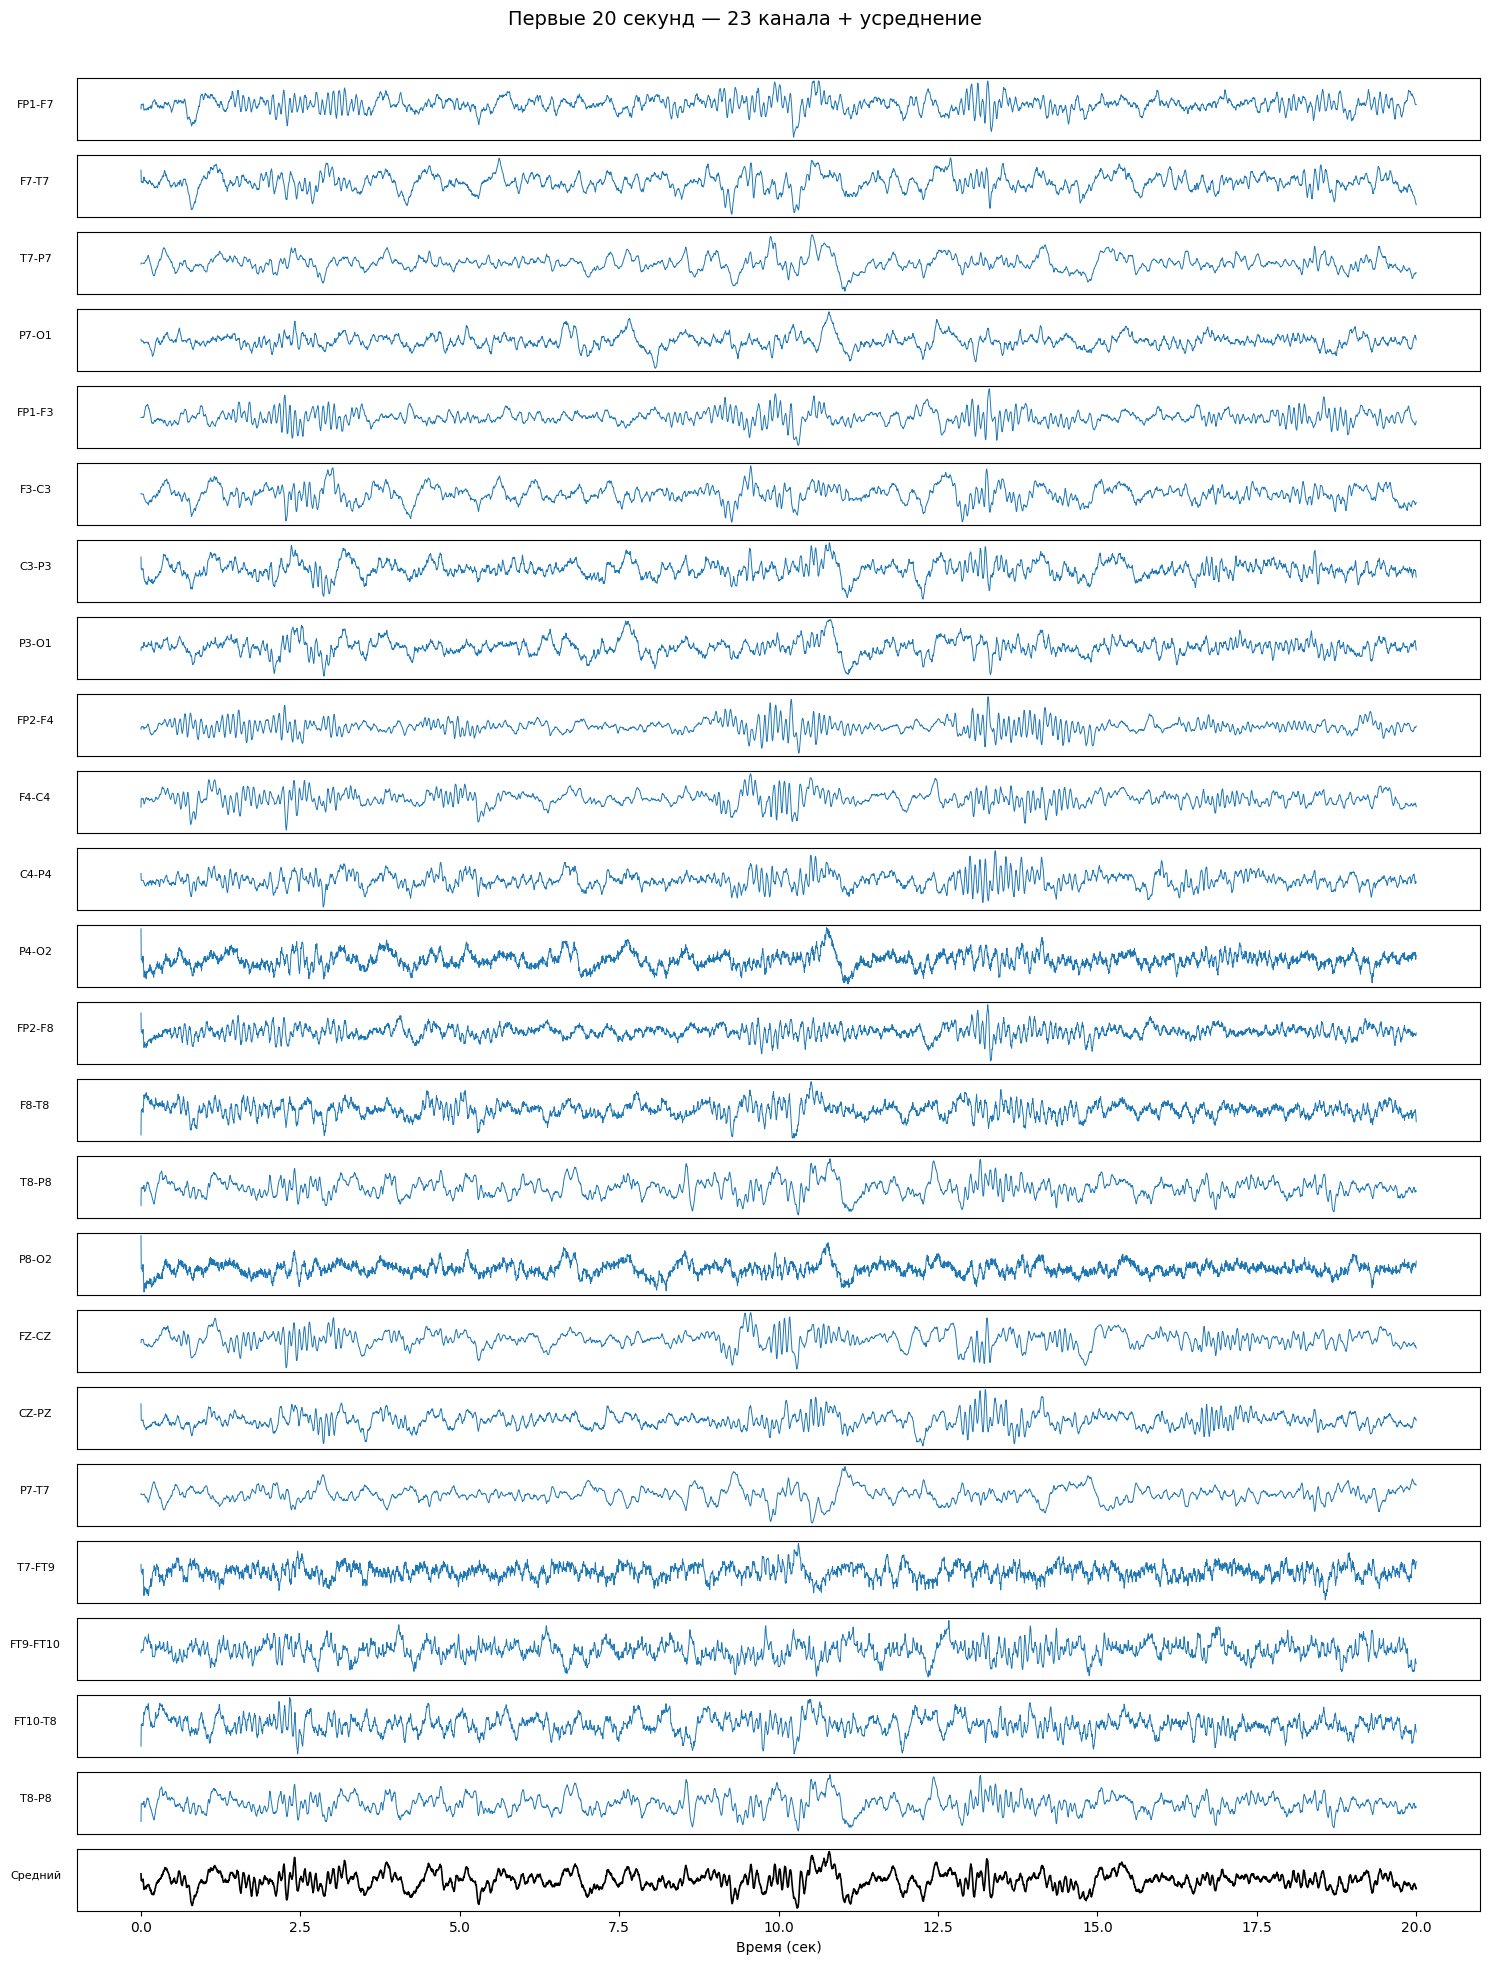

In [2]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt

def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n_channels = f.signals_in_file
        signal_labels = f.getSignalLabels()
        n_samples = f.getNSamples()[0]
        signals = np.zeros((n_channels, n_samples))
        for i in range(n_channels):
            signals[i, :] = f.readSignal(i)
    return signals, signal_labels

# === НАСТРОЙКИ ===
edf_path = r"chbmit_data\seizure\chb01_03.edf" 
duration_seconds = 20
sampling_rate = 256

# === ЧТЕНИЕ ===
signals, labels = read_edf(edf_path)
samples_to_show = duration_seconds * sampling_rate
time_axis = np.linspace(0, duration_seconds, samples_to_show)

# === 1. ВСЕ КАНАЛЫ ===
plt.figure(figsize=(15, 20))
for i in range(23):
    plt.subplot(24, 1, i + 1)
    plt.plot(time_axis, signals[i, :samples_to_show], linewidth=0.7)
    plt.ylabel(labels[i], rotation=0, labelpad=30, fontsize=8)
    plt.xticks([])
    plt.yticks([])

# === 2. УСРЕДНЁННЫЙ СИГНАЛ ===
avg_signal = np.mean(signals[:, :samples_to_show], axis=0)
plt.subplot(24, 1, 24)
plt.plot(time_axis, avg_signal, color='black', linewidth=1.2)
plt.ylabel("Средний", rotation=0, labelpad=30, fontsize=8)
plt.xlabel("Время (сек)")
plt.yticks([])

plt.suptitle(f"Первые {duration_seconds} секунд — 23 канала + усреднение", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Task 2-3. Create Images

In [3]:
def parse_seizure_annotations(txt_folder_path):
    seizure_dict = {}

    for filename in os.listdir(txt_folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(txt_folder_path, filename), "r", encoding="utf-8") as file:
                lines = file.readlines()

            current_file = None
            current_seizures = []

            for line in lines:
                line = line.strip()

                if line.startswith("File Name:"):
                    if current_file and current_seizures:
                        seizure_dict[current_file] = current_seizures
                    current_file = line.split("File Name:")[1].strip()
                    current_seizures = []

                # универсальный матчинг на строки с "Seizure * Start Time"
                match_start = re.match(r"Seizure\s+\d*\s*Start Time:\s*(\d+)", line)
                match_end = re.match(r"Seizure\s+\d*\s*End Time:\s*(\d+)", line)

                if match_start:
                    start = int(match_start.group(1))
                if match_end:
                    end = int(match_end.group(1))
                    current_seizures.append((start, end))

            if current_file and current_seizures:
                seizure_dict[current_file] = current_seizures

    return seizure_dict

# Пример использования:
txt_folder = r"D:\Рабочий стол\Studying\4Semestr\PPA\Labs\chbmit_data\txt"
seizures = parse_seizure_annotations(txt_folder)
print(len(seizures))


87


In [4]:
import os
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
import pyedflib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pywt
import re

# === Настройки путей ===
base_path = r"D:\Рабочий стол\Studying\4Semestr\PPA\Labs\chbmit_data"
txt_path = os.path.join(base_path, "txt")
edf_seizure_path = os.path.join(base_path, "seizure")
edf_normal_path = os.path.join(base_path, "non_seizure")
output_seizure = os.path.join(base_path, "wavelet_img", "Seizure")
output_healthy = os.path.join(base_path, "wavelet_img", "Healthy")

os.makedirs(output_seizure, exist_ok=True)
os.makedirs(output_healthy, exist_ok=True)

# === Функция: Парсинг аннотаций ===
def parse_seizure_annotations(txt_folder_path):
    seizure_dict = {}
    for filename in os.listdir(txt_folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(txt_folder_path, filename), "r", encoding="utf-8") as file:
                lines = file.readlines()
            current_file = None
            current_seizures = []
            for line in lines:
                line = line.strip()
                if line.startswith("File Name:"):
                    if current_file and current_seizures:
                        seizure_dict[current_file] = current_seizures
                    current_file = line.split("File Name:")[1].strip()
                    current_seizures = []
                match_start = re.match(r"Seizure\s+\d*\s*Start Time:\s*(\d+)", line)
                match_end = re.match(r"Seizure\s+\d*\s*End Time:\s*(\d+)", line)
                if match_start:
                    start = int(match_start.group(1))
                if match_end:
                    end = int(match_end.group(1))
                    current_seizures.append((start, end))
            if current_file and current_seizures:
                seizure_dict[current_file] = current_seizures
    return seizure_dict

# === Функция: Чтение EDF ===
def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signals = np.zeros((n, f.getNSamples()[0]))
        for i in range(n):
            signals[i, :] = f.readSignal(i)
    return signals

# === Функция: Баттерворт + диапазоны ===
def butter_bandpass_filter(data, fs, order=5):
    bands = [(1, 4), (4, 8), (8, 14), (14, 20), (30, 50)]
    nyq = 0.5 * fs
    filtered_signals = []
    for low, high in bands:
        b, a = signal.butter(order, [low/nyq, high/nyq], btype='band')
        filtered = signal.lfilter(b, a, data)
        filtered_signals.append(filtered)
    return filtered_signals

# === Функция: Вейвлет и сохранение ===
def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):
    scale_max = [200, 50, 26, 14, 6]
    scale_min = [50, 26, 14, 6, 3.5]
    v_max = [240, 120, 40, 30, 20]
    wavelet_core = 'morl'
    dt = 1 / sampling_rate
    fig, axs = plt.subplots(5, 1, figsize=(10, 12))
    for k in range(len(signal)):
        scales = np.linspace(scale_min[k], scale_max[k], num=25)
        coef, freqs = pywt.cwt(signal[k], scales, wavelet_core, sampling_period=dt)
        frequencies = pywt.scale2frequency(wavelet_core, scales) / dt
        extent = [start_time, end_time, frequencies[-1], frequencies[0]]
        colors = [(0, 'blue'), (0.5, 'cyan'), (0.9, 'yellow'), (1, 'darkred')]
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
        axs[k].imshow(np.abs(coef), extent=extent, cmap=cmap, aspect='auto', vmin=0, vmax=v_max[k])
        axs[k].set_ylabel('Freq (Hz)')
        axs[k].set_ylim(frequencies[-1], frequencies[0])
    axs[-1].set_xlabel("Time (sec)")
    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{file_name}_{time_label}_wavelet.png")
    plt.savefig(save_path)
    plt.close(fig)

# === Применяем ===
sampling_rate = 256
seizures = parse_seizure_annotations(txt_path)

'''

#  Файлы с приступами
for edf_name, seizure_list in seizures.items():
    edf_path = os.path.join(edf_seizure_path, edf_name)
    if not os.path.exists(edf_path):
        continue
    signals = read_edf(edf_path)
    for i, (start, _) in enumerate(seizure_list):
        if start < 30: continue  # чтобы не уйти в отрицательные
        start_sec = start
        end_sec = start+30
        s_start, s_end = start_sec * sampling_rate, end_sec * sampling_rate
        avg_signal = np.mean(signals[:, s_start:s_end], axis=0)
        filtered = butter_bandpass_filter(avg_signal, sampling_rate)
        save_wavelet_transform(filtered, edf_name.replace(".edf", ""), output_seizure, start_sec, end_sec, sampling_rate, f"pre_{i+1}")

#  Файлы без приступов
for edf_name in os.listdir(edf_normal_path):
    if not edf_name.endswith(".edf"):
        continue
    edf_path = os.path.join(edf_normal_path, edf_name)
    signals = read_edf(edf_path)
    total_seconds = signals.shape[1] // sampling_rate
    if total_seconds < 60: continue
    start_sec = total_seconds // 2
    end_sec = start_sec + 30
    s_start, s_end = start_sec * sampling_rate, end_sec * sampling_rate
    avg_signal = np.mean(signals[:, s_start:s_end], axis=0)
    filtered = butter_bandpass_filter(avg_signal, sampling_rate)
    save_wavelet_transform(filtered, edf_name.replace(".edf", ""), output_healthy, start_sec, end_sec, sampling_rate, "healthy")
'''

'\n\n#  Файлы с приступами\nfor edf_name, seizure_list in seizures.items():\n    edf_path = os.path.join(edf_seizure_path, edf_name)\n    if not os.path.exists(edf_path):\n        continue\n    signals = read_edf(edf_path)\n    for i, (start, _) in enumerate(seizure_list):\n        if start < 30: continue  # чтобы не уйти в отрицательные\n        start_sec = start\n        end_sec = start+30\n        s_start, s_end = start_sec * sampling_rate, end_sec * sampling_rate\n        avg_signal = np.mean(signals[:, s_start:s_end], axis=0)\n        filtered = butter_bandpass_filter(avg_signal, sampling_rate)\n        save_wavelet_transform(filtered, edf_name.replace(".edf", ""), output_seizure, start_sec, end_sec, sampling_rate, f"pre_{i+1}")\n\n#  Файлы без приступов\nfor edf_name in os.listdir(edf_normal_path):\n    if not edf_name.endswith(".edf"):\n        continue\n    edf_path = os.path.join(edf_normal_path, edf_name)\n    signals = read_edf(edf_path)\n    total_seconds = signals.shape[1]

## Task 4. CNN + LSTM

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [7]:

# Функция для загрузки изображений
def load_images(image_dir, target_size):
    images = []
    labels = []
    for class_dir in ['Healthy', 'Seizure']:  # Подкаталоги классов
        class_path = os.path.join(image_dir, class_dir)
        label = 0 if class_dir == 'Healthy' else 1  # Классы кодируются как 0 или 1
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            # plt.figure()
            # plt.imshow(img)
            img = tf.image.resize(img, target_size)  # Изменение размеров изображения
            images.append(img)
            labels.append(label)
    plt.show()
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [8]:
def display_samples(X, y, num_samples, dataset_name="Dataset"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = X[i]
        
        # Если 4 канала → отбросить альфа-канал
        if img.shape[-1] == 4:
            img = img[:, :, :3]
        
        plt.imshow(img)
        plt.title(f"Label: {y[i]}")
        plt.axis('off')

    plt.suptitle(f"Sample images from {dataset_name}")
    plt.tight_layout()
    plt.show()


In [9]:
import os
image_dir = r"D:\Рабочий стол\Studying\4Semestr\PPA\Labs\chbmit_data\wavelet_img"
# Загрузка данных
#X, y = load_images(image_dir, (700,700))
X, y = load_images(image_dir, (512,512))
# print(X[1,32,32,:])
# Масштабирование изображений (нормализация)
#X = X / 255.0
X, y = shuffle(X, y, random_state=24)
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(X.shape)  # должно быть (N, 512, 512, 4)
print(y.shape)  # должно быть (N,)

(101, 512, 512, 4)
(101,)


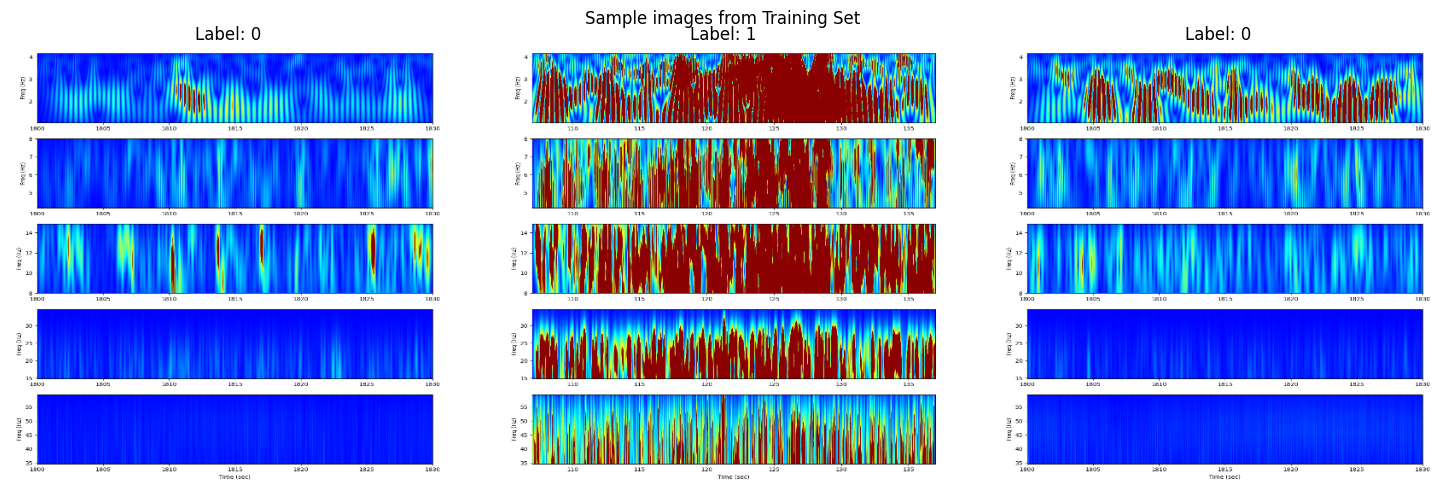

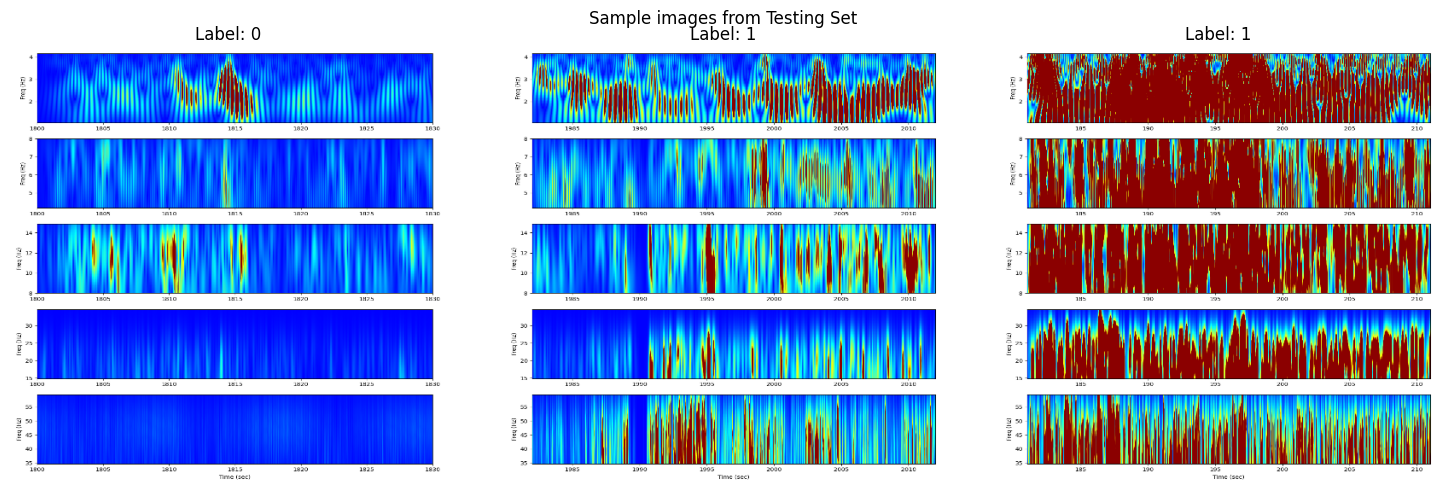

In [11]:
# Вывод примеров из тестовой выборки
# Вывод примеров из обучающей выборки
display_samples(X_train, y_train, num_samples=3, dataset_name="Training Set")
display_samples(X_test, y_test, num_samples=3, dataset_name="Testing Set")

In [12]:
# Преобразование меток в категориальный формат (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [13]:
# Построение модели
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # для 2 классов

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Инициализация и обучение
input_shape = (512, 512, 4)  # Учитывая RGBA
model = create_cnn_model(input_shape)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint("cnn_best_weights.keras", monitor="val_accuracy", save_best_only=True, mode="max")


d:\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 512, 512, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512, 512, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      33,554,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,649,058 (128.36 MB)

 Trainable params: 33,648,610 (128.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# Обучение модели
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# Преобразование меток обратно из one-hot encoding в одномерный массив меток
y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь, так как model.fit ожидает словарь
class_weights_dict = dict(enumerate(class_weights))
checkpoint = ModelCheckpoint(
    "best_weights.keras",  # Имя файла для сохранения весов
    monitor="val_accuracy",  # Метрика для отслеживания
    save_best_only=True,     # Сохранять только если улучшилась метрика
    mode="max",              # "max" для максимизации метрики
    verbose=1
)



In [15]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=8,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)

# Оценка
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))

Epoch 1/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4801 - loss: 6.6965
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4979 - loss: 6.5602 - val_accuracy: 0.2500 - val_loss: 1.4650
Epoch 2/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.9820 - loss: 0.2938
Epoch 2: val_accuracy improved from 0.25000 to 0.87500, saving model to best_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9771 - loss: 0.3704 - val_accuracy: 0.8750 - val_loss: 0.2866
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       1.00      0.71      0.83        14

    accuracy                           0.81        21
   macro avg       0.82      0.86      0.81        21
weighted avg       0.88      0.81      0.81        21

Accuracy: 0.8095238095238095


In [16]:

y_pred_classes

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])

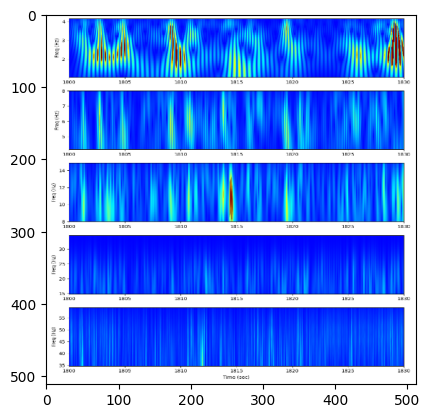

In [17]:

#y_pred = model.predict(X_test)
plt.imshow(X_test[9])

## Task 5. Testing

In [18]:
#сохранение модели
#model.save('cnn_eeg_epilepsy_model.keras')
#model_loaded = tf.keras.models.load_model('cnn_eeg_epilepsy_model.h5')
# Сохранение весов
#model.save_weights("model_weights.weights.h5")

# Загрузка весов в ту же архитектуру модели
#model.load_weights("model_weights.h5")

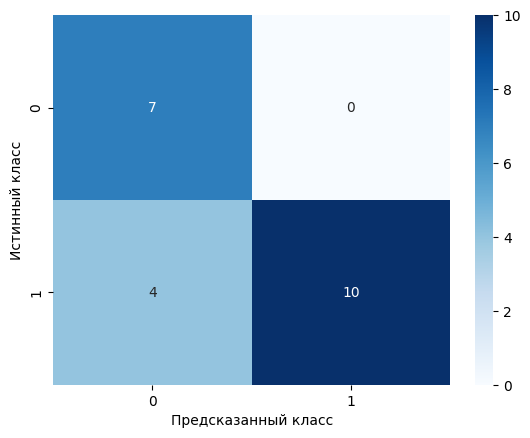

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
# Построение матрицы ошибок
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step


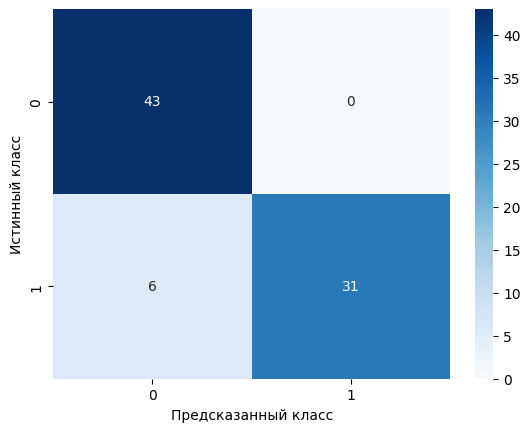

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
y_pred_train = model.predict(X_train)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)
y_true_train = np.argmax(y_train, axis=1)

conf_matrix_train = confusion_matrix(y_true_train, y_pred_classes_train)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

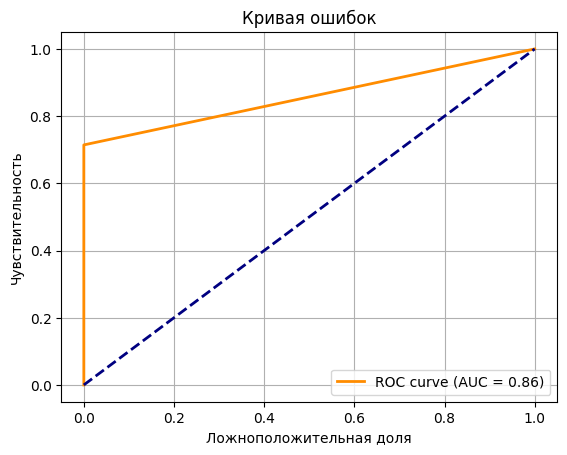

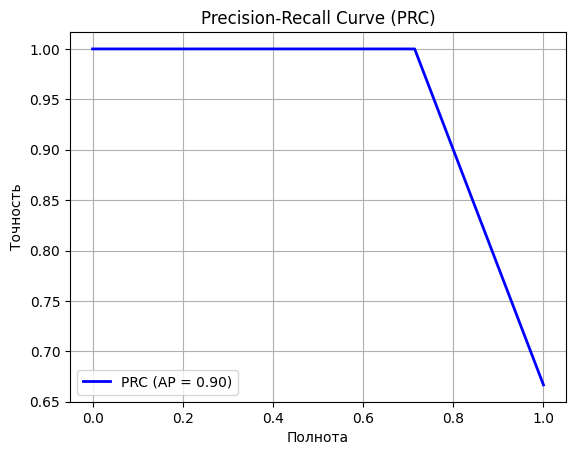

In [21]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_true, y_pred_classes)  # Используем вероятности для классов

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Диагональная линия
plt.xlabel('Ложноположительная доля')
plt.ylabel('Чувствительность')
plt.title('Кривая ошибок')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Построение Precision-Recall кривой
precision, recall, _ = precision_recall_curve(y_true, y_pred_classes)
average_precision = average_precision_score(y_true, y_pred_classes)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (AP = {average_precision:.2f})')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.grid()
plt.show()

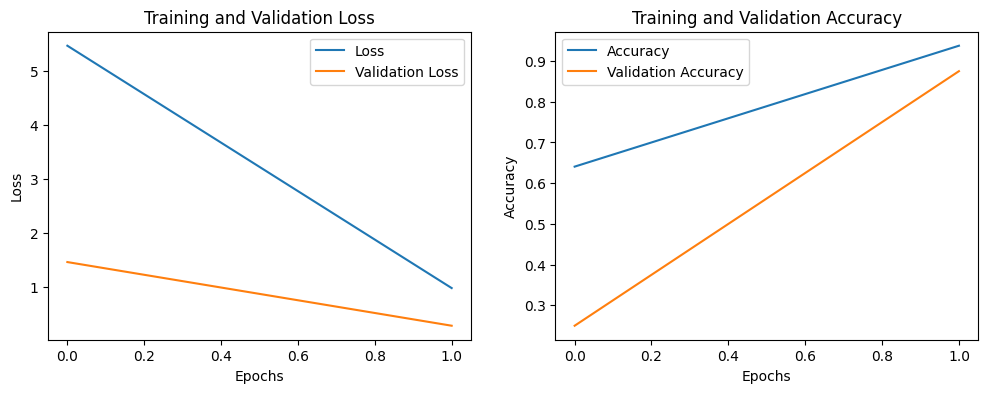

In [22]:

# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.close()  # Закрыть график, чтобы избежать наложения

## Task 5.1 Testing on validation data

In [23]:
'''
# Настройки путей
base_path = r"D:\Рабочий стол\Studying\4Semestr\PPA\Labs\chbmit_data"
edf_normal_path = os.path.join(base_path, "non_seizure")
output_healthy_test = os.path.join(base_path, "tests", "Healthy")

#os.makedirs(output_seizure, exist_ok=True)
os.makedirs(output_healthy_test, exist_ok=True)

#  Файлы без приступов
for edf_name in os.listdir(edf_normal_path):
    if not edf_name.endswith(".edf"):
        continue
    edf_path = os.path.join(edf_normal_path, edf_name)
    signals = read_edf(edf_path)
    total_seconds = signals.shape[1] // sampling_rate
    if total_seconds < 60: continue
    start_sec = total_seconds // 4
    end_sec = start_sec + 30
    s_start, s_end = start_sec * sampling_rate, end_sec * sampling_rate
    avg_signal = np.mean(signals[:, s_start:s_end], axis=0)
    filtered = butter_bandpass_filter(avg_signal, sampling_rate)
    save_wavelet_transform(filtered, edf_name.replace(".edf", ""), output_healthy_test, start_sec, end_sec, sampling_rate, "healthy")

'''

'\n# Настройки путей\nbase_path = r"D:\\Рабочий стол\\Studying\x04Semestr\\PPA\\Labs\\chbmit_data"\nedf_normal_path = os.path.join(base_path, "non_seizure")\noutput_healthy_test = os.path.join(base_path, "tests", "Healthy")\n\n#os.makedirs(output_seizure, exist_ok=True)\nos.makedirs(output_healthy_test, exist_ok=True)\n\n#  Файлы без приступов\nfor edf_name in os.listdir(edf_normal_path):\n    if not edf_name.endswith(".edf"):\n        continue\n    edf_path = os.path.join(edf_normal_path, edf_name)\n    signals = read_edf(edf_path)\n    total_seconds = signals.shape[1] // sampling_rate\n    if total_seconds < 60: continue\n    start_sec = total_seconds // 4\n    end_sec = start_sec + 30\n    s_start, s_end = start_sec * sampling_rate, end_sec * sampling_rate\n    avg_signal = np.mean(signals[:, s_start:s_end], axis=0)\n    filtered = butter_bandpass_filter(avg_signal, sampling_rate)\n    save_wavelet_transform(filtered, edf_name.replace(".edf", ""), output_healthy_test, start_sec, end

In [24]:
test_files_dir = r"D:\Рабочий стол\Studying\4Semestr\PPA\Labs\chbmit_data\tests"
X_testing, y_testing = load_images(test_files_dir, (512,512))
X_testing, y_testing = shuffle(X_testing, y_testing, random_state=24)
y_testing = tf.keras.utils.to_categorical(y_testing, num_classes=2)

In [25]:
# Оценка модели на тестовых данных
y_pred_testing = model.predict(X_testing)
y_pred_classes_testing = np.argmax(y_pred_testing, axis=1)
y_true_testing = np.argmax(y_testing, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step


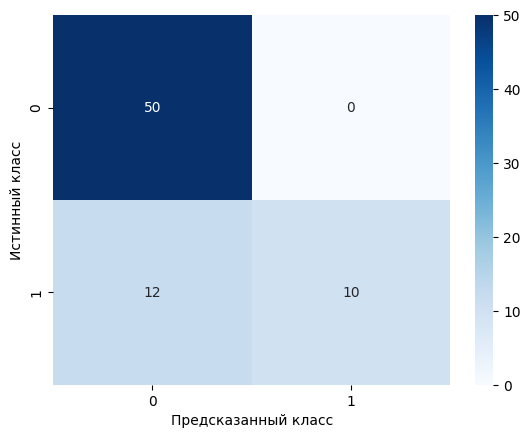

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
conf_matrix_testing = confusion_matrix(y_true_testing, y_pred_classes_testing)
sns.heatmap(conf_matrix_testing, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

## Task6. AutoML

### AutoKeras

In [27]:
import autokeras as ak
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [28]:
import os
image_dir = r"D:\Рабочий стол\Studying\4Semestr\PPA\Labs\chbmit_data\wavelet_img"
# Загрузка данных
#X, y = load_images(image_dir, (700,700))
X, y = load_images(image_dir, (128,128))
# print(X[1,32,32,:])
# Масштабирование изображений (нормализация)
#X = X / 255.0
X, y = shuffle(X, y, random_state=24)
X = X[..., :3]
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
y_test

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [30]:
# 4. Создание AutoKeras ImageClassifier
clf = ak.ImageClassifier(
    max_trials=1,
    objective='val_accuracy',
    overwrite=True,
    seed=42,
    directory = "D:/autokeras_project", 
    project_name='my_image_project'
)

# 5. Обучение модели
clf.fit(X_train, y_train, epochs=2, validation_split=0.2)


Trial 1 Complete [00h 00m 02s]
val_accuracy: 0.875

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 00m 02s
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6484 - loss: 1.0827
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9211 - loss: 0.3815


In [31]:
model = clf.export_model()
#model.save("best_autokeras_model.keras")

d:\python\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
from tensorflow.keras.models import load_model
model_l = load_model("best_autokeras_model.keras")

preds = model_l.predict(X_test)
preds_classes = (preds > 0.5).astype(int)

d:\python\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [33]:
preds_classes

array([[0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

In [34]:
print("Accuracy:", accuracy_score(y_test, preds_classes))

Accuracy: 0.9523809523809523


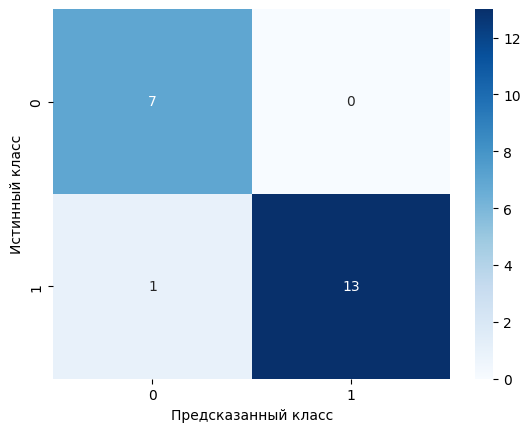

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
conf_matrix_testing = confusion_matrix(y_test, preds_classes)
sns.heatmap(conf_matrix_testing, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

In [36]:
preds_train = model_l.predict(X_train)
preds_classes_train = (preds_train > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


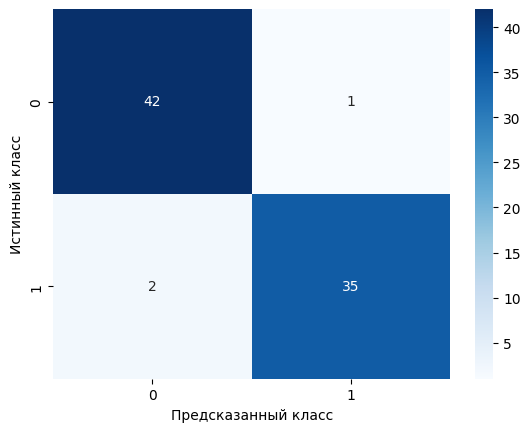

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [37]:
conf_matrix_testing = confusion_matrix(y_train, preds_classes_train)
sns.heatmap(conf_matrix_testing, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

### Lama

In [47]:
import pandas as pd
from lightautoml.tasks import Task
from lightautoml.automl.presets.image_presets import TabularCVAutoML

d:\python\lib\site-packages\lightautoml\image\image.py:17: UserWarning: 'cv2' - package isn't installed
  warnings.warn("'cv2' - package isn't installed")


'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


d:\python\lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
d:\python\lib\site-packages\lightautoml\text\embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
d:\python\lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [51]:
healthy_images = []
dir_name = './chbmit_data/wavelet_img/Healthy'
for path in os.listdir(dir_name):
    healthy_images.append(f'{dir_name}/{path}')

healthy_images[0]

'./chbmit_data/wavelet_img/Healthy/chb01_01_healthy_wavelet.png'

In [52]:
seizure_images = []
dir_name = './chbmit_data/wavelet_img/Seizure' 
for path in os.listdir(dir_name):
    seizure_images.append(f'{dir_name}/{path}')

In [53]:
data = pd.DataFrame(
    {
        'path': healthy_images + seizure_images,
        'label': [0] * len(healthy_images) + [1] * len(seizure_images)
    }
)
data

,path,label
0,./chbmit_data/wavelet_img/Healthy/chb01_01_hea...,0
1,./chbmit_data/wavelet_img/Healthy/chb01_02_hea...,0
2,./chbmit_data/wavelet_img/Healthy/chb01_05_hea...,0
3,./chbmit_data/wavelet_img/Healthy/chb01_06_hea...,0
4,./chbmit_data/wavelet_img/Healthy/chb01_07_hea...,0
...,...,...
96,./chbmit_data/wavelet_img/Seizure/chb12_29_pre...,1
97,./chbmit_data/wavelet_img/Seizure/chb12_29_pre...,1
98,./chbmit_data/wavelet_img/Seizure/chb12_29_pre...,1
99,./chbmit_data/wavelet_img/Seizure/chb13_21_pre...,1


In [54]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

In [55]:
automl = TabularCVAutoML(
    task = Task('binary'),
    timeout=5 * 3600,
    cpu_limit = 2,
    reader_params = {'cv': 5, 'random_state': 50}
)

In [56]:
predictions = automl.fit_predict(train_data, roles={'target': 'label', 'path': ['path']}, verbose=3)

[11:34:41] Stdout logging level is INFO3.
[11:34:41] Task: binary

[11:34:41] Start automl preset with listed constraints:
[11:34:41] - time: 18000.00 seconds
[11:34:41] - CPU: 2 cores
[11:34:41] - memory: 16 GB

[11:34:41] Train data shape: (80, 2)

[11:34:41] Layer 1 train process start. Time left 17999.97 secs


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/repos/18/5c/185c125a6ece1d7df702fd008ff2f572466275ce8bb3b27daeb0996245f790e4/2d31bb5597c720912f8ea5e4f1de73909a6911798d78ae5d1b9d63a955fed049?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1745314487&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTMxNDQ4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xOC81Yy8xODVjMTI1YTZlY2UxZDdkZjcwMmZkMDA4ZmYyZjU3MjQ2NjI3NWNlOGJiM2IyN2RhZWIwOTk2MjQ1Zjc5MGU0LzJkMzFiYjU1OTdjNzIwOTEyZjhlYTVlNGYxZGU3MzkwOWE2OTExNzk4ZDc4YWU1ZDFiOWQ2M2E5NTVmZWQwNDk%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=qpItqg8jnXNt6HrhRw-SN2pVKzPJRIihPmK1CWioPGR8DYGlb5hSUGVE%7Eo7UB1jVd2dBozdiv8cloaCCr3MG60gM42QutPDOV1xPijsTVoXf4Ywzs7VfEz8rX67KZL6P-dtiRWjyo3YXNfQ5g-9cUMenBA%7ElMh1IGJu7dLAHlnp2aOwFD5CprGT7q%7EkslJwn44vs%7E3wtSOF1cx2q6rN8Hf3HSvkiVM1%7EHVLjyIx1oe5NyzftSRL6-E68HuIE0W3P6

ConnectionError: (MaxRetryError('HTTPSConnectionPool(host=\'cdn-lfs.hf.co\', port=443): Max retries exceeded with url: /repos/18/5c/185c125a6ece1d7df702fd008ff2f572466275ce8bb3b27daeb0996245f790e4/2d31bb5597c720912f8ea5e4f1de73909a6911798d78ae5d1b9d63a955fed049?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1745314487&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTMxNDQ4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xOC81Yy8xODVjMTI1YTZlY2UxZDdkZjcwMmZkMDA4ZmYyZjU3MjQ2NjI3NWNlOGJiM2IyN2RhZWIwOTk2MjQ1Zjc5MGU0LzJkMzFiYjU1OTdjNzIwOTEyZjhlYTVlNGYxZGU3MzkwOWE2OTExNzk4ZDc4YWU1ZDFiOWQ2M2E5NTVmZWQwNDk~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=qpItqg8jnXNt6HrhRw-SN2pVKzPJRIihPmK1CWioPGR8DYGlb5hSUGVE~o7UB1jVd2dBozdiv8cloaCCr3MG60gM42QutPDOV1xPijsTVoXf4Ywzs7VfEz8rX67KZL6P-dtiRWjyo3YXNfQ5g-9cUMenBA~lMh1IGJu7dLAHlnp2aOwFD5CprGT7q~kslJwn44vs~3wtSOF1cx2q6rN8Hf3HSvkiVM1~HVLjyIx1oe5NyzftSRL6-E68HuIE0W3P688Ly1YOn3ogbZ2lWNkBTGZg5JE2YYmfz2DSVSUnWnUyeyB3Gquu7DuQfiIyO4ngsCXfvOEcOJKMTOZGnsZ6PA__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000179536B04C0>: Failed to resolve \'cdn-lfs.hf.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: a725b56b-98df-455a-b394-6ad92ebeedd9)')

## Развёртывание

In [38]:
import joblib
from fastapi import FastAPI
from pydantic import BaseModel
from threading import Thread
import uvicorn

In [39]:
# Загрузка модели Keras
model_path = 'best_autokeras_model.keras'
keras_model = load_model(model_path)

# FastAPI приложение
app = FastAPI()

# Пример данных от пользователя
class DataInput(BaseModel):
    features: list  # Список признаков (одна строка)

# Эндпоинт для предсказания
@app.post("/predict/")
async def predict(data: DataInput):
    features = np.array(data.features).reshape(1, -1)  # (1, n_features)
    prediction = keras_model.predict(features)
    class_prediction = int((prediction > 0.5).astype("int")[0][0])  # для бинарной классификации
    return {"prediction": class_prediction}

# Эндпоинт для метрик
@app.get("/metrics/")
async def get_metrics():
    # ⚠️ Эти переменные ты должен определить заранее (или подключить откуда-то)
    global X_test, y_test

    probs = keras_model.predict(X_test)
    preds = (probs > 0.5).astype("int").flatten()

    f1_macro = f1_score(y_test, preds, average="macro")
    f1_weighted = f1_score(y_test, preds, average="weighted")
    cm = confusion_matrix(y_test, preds)

    return {
        "F1 Macro": f1_macro,
        "F1 Weighted": f1_weighted,
        "Confusion Matrix": cm.tolist()
    }

# Запуск Uvicorn в отдельном потоке
def run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

server_thread = Thread(target=run_uvicorn)
server_thread.start()

print("Server is running at http://127.0.0.1:8000")

Server is running at http://127.0.0.1:8000


d:\python\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
INFO:     Started server process [19132]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
